# CEO-Request Challenge

In [90]:
import sys
sys.path.insert(0, "/home/tumay/code/data-context-and-setup")

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


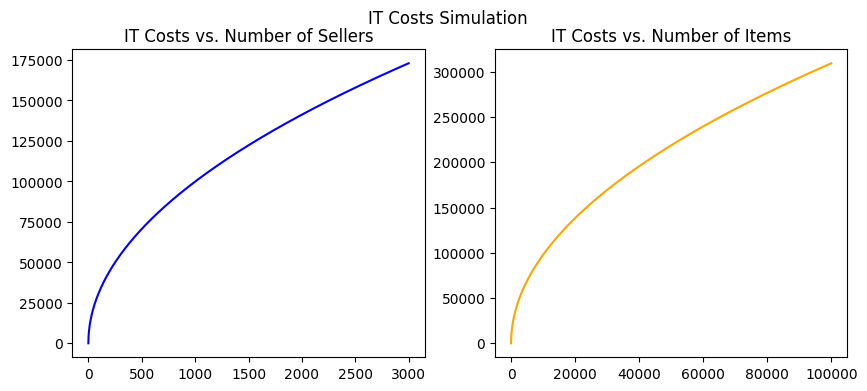

In [91]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

In [92]:
from olist.seller_updated import Seller
seller = Seller()

In [93]:
sellers = seller.get_training_data()

In [94]:
metrics_ordered = sellers[['revenues', 'cost_of_reviews', 'profits', 'quantity']] \
                  .sort_values(by='profits', ascending=False) \
                  .reset_index().drop(columns='index')
metrics_ordered.cost_of_reviews *= -1
metrics_ordered['n_sellers'] = 1
metrics_ordered


,revenues,cost_of_reviews,profits,quantity,n_sellers
0,23237.605,-5170,18067.605,410,1
1,19323.187,-4700,14623.187,340,1
2,21004.203,-6510,14494.203,586,1
3,8808.455,-1520,7288.455,175,1
4,14651.119,-7500,7151.119,542,1
...,...,...,...,...,...
2962,2553.569,-15440,-12886.431,1018,1
2963,4677.752,-20220,-15542.248,1203,1
2964,11948.842,-29530,-17581.158,1775,1
2965,21647.292,-39400,-17752.708,1987,1


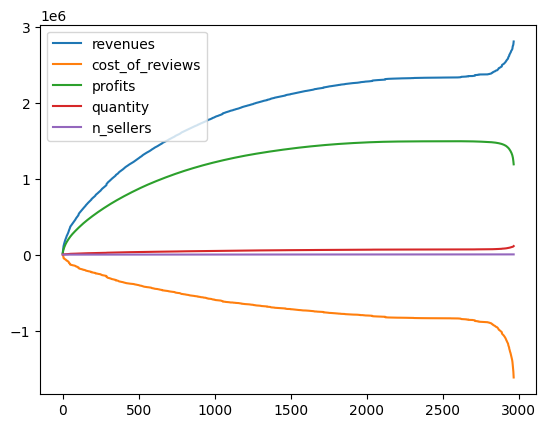

In [95]:
metrics_cumulative = metrics_ordered.cumsum()
metrics_cumulative.plot();

<Axes: >

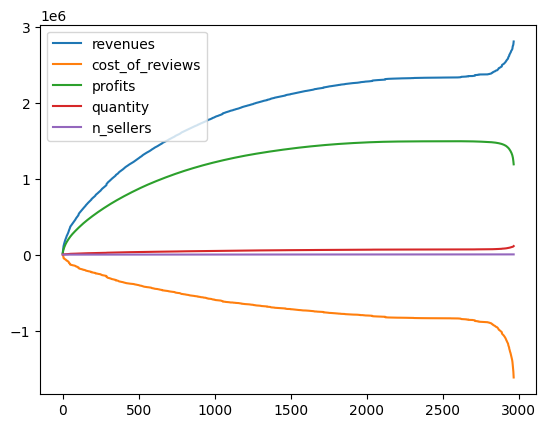

In [96]:
metrics_ordered = (
    sellers[['revenues','cost_of_reviews','profits','quantity']]
    .sort_values(by='profits', ascending=False)
    .reset_index(drop=True)
)

# çözümde genelde maliyeti "pozitif" göstermek için çeviriyorlar
metrics_ordered['cost_of_reviews'] *= -1
metrics_ordered['n_sellers'] = 1

metrics_cumulative = metrics_ordered.cumsum()
metrics_cumulative.plot()


In [97]:
optimum_without_it = metrics_cumulative.profits.argmax()
optimum_without_it

2595

,impact
revenues,-473776.488
cost_of_reviews,778040.000
profits,304263.512
quantity,-44938.000
n_sellers,-371.000


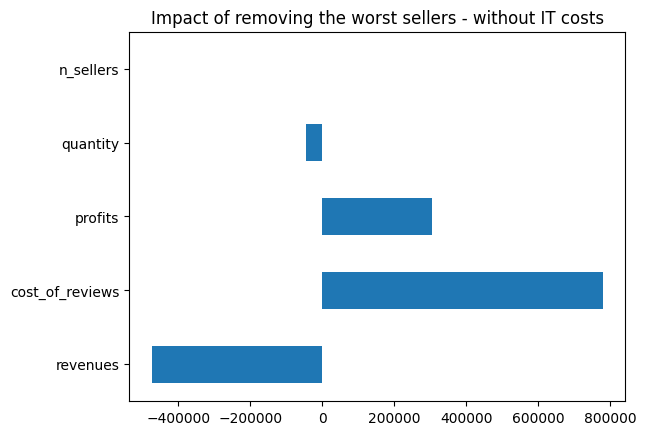

In [98]:
# Calculating the impact of removing the worst sellers
impact_without_it_costs = metrics_cumulative.iloc[optimum_without_it] - metrics_ordered.sum()
display(pd.DataFrame(impact_without_it_costs, columns=["impact"]))
impact_without_it_costs.plot(kind='barh', title="Impact of removing the worst sellers - without IT costs");

### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


In [99]:
def cost_of_it(sellers, alpha, beta):
    """
    Function to calculate the IT costs
    """
    it_costs = alpha * sellers['n_sellers'] ** 0.5 + beta * sellers['quantity'] ** 0.5
    return it_costs

In [100]:
metrics_cumulative_with_it = metrics_ordered.cumsum()

In [101]:
metrics_cumulative_with_it['it_costs'] = - cost_of_it(metrics_cumulative_with_it, alpha, beta)
metrics_cumulative_with_it

,revenues,cost_of_reviews,profits,quantity,n_sellers,it_costs
0,23237.605,-5170,18067.605,410,1,-22964.917828
1,42560.792,-9870,32690.792,750,2,-31254.985925
2,63564.995,-16380,47184.995,1336,3,-41224.163282
3,72373.450,-17900,54473.450,1511,4,-44339.889079
4,87024.569,-25400,61624.569,2053,5,-51383.513743
...,...,...,...,...,...,...
2962,2755294.075,-1493770,1261524.075,105443,2963,-489511.812301
2963,2759971.827,-1513990,1245981.827,106646,2964,-491347.711731
2964,2771920.669,-1543520,1228400.669,108421,2965,-494024.237152
2965,2793567.961,-1582920,1210647.961,110408,2966,-496991.389117


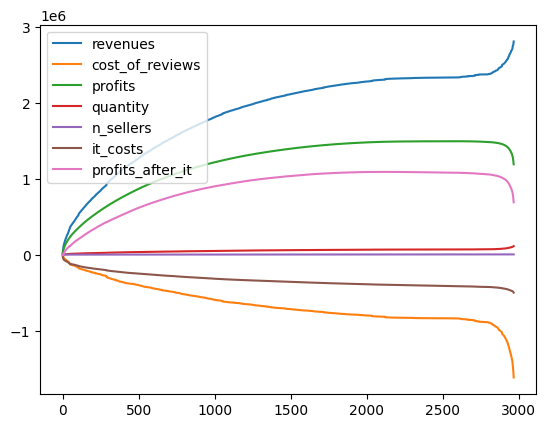

In [102]:
metrics_cumulative_with_it['profits_after_it'] = metrics_cumulative_with_it['profits'] + metrics_cumulative_with_it['it_costs']
metrics_cumulative_with_it.plot();

In [103]:
optimum_with_it = metrics_cumulative_with_it.profits_after_it.argmax()
optimum_with_it

2116

,impact
cost_of_reviews,799940.000000
it_costs,84976.134133
n_sellers,-850.000000
profits,297156.809000
profits_after_it,389239.646133
quantity,-46481.000000
revenues,-502783.191000


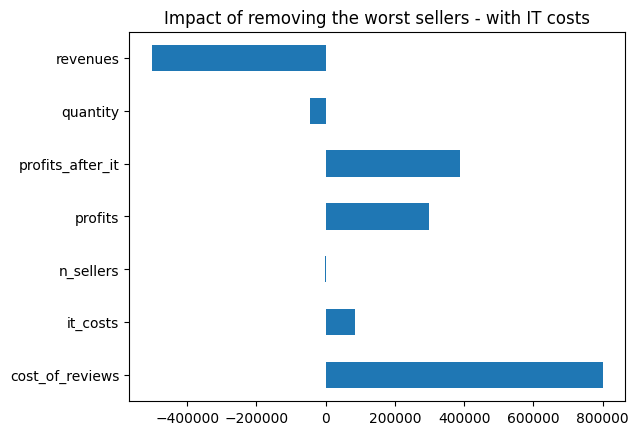

In [104]:
# Calculating the impact of removing the worst sellers
impact_with_it_costs = metrics_cumulative_with_it.iloc[optimum_with_it] - metrics_ordered.sum()
impact_with_it_costs['it_costs'] = metrics_cumulative_with_it.it_costs.iloc[optimum_without_it] \
                                 - metrics_cumulative_with_it.it_costs.iloc[-1]
impact_with_it_costs['profits_after_it'] = metrics_cumulative_with_it.profits_after_it.iloc[optimum_without_it] \
                                         - metrics_cumulative_with_it.profits_after_it.iloc[-1]
display(pd.DataFrame(impact_with_it_costs, columns=["impact"]))
impact_with_it_costs.plot(kind='barh', title="Impact of removing the worst sellers - with IT costs");

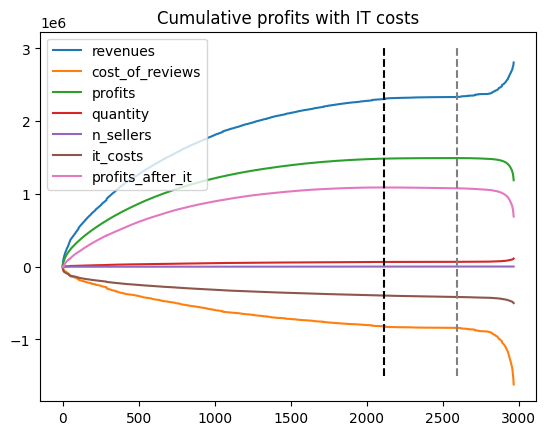

In [105]:
metrics_cumulative_with_it.plot(title="Cumulative profits with IT costs")
plt.vlines(optimum_with_it, ymin=-1.5e6, ymax=3e6, color='black', linestyle='--')
plt.vlines(optimum_without_it, ymin=-1.5e6, ymax=3e6, color='grey', linestyle='--');

## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪

In [106]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from IPython.display import Markdown as md

In [107]:
from olist.seller_updated import Seller
seller = Seller()

In [108]:
sellers = seller.get_training_data()

In [109]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,1.514329,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,140,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.155190,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55,240,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.000000,1.000000,5.00,0,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.000000,1.000000,5.00,0,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.00,100,16.799,-83.201


# 💰 Genel Bakış: Olist Mali Durumu

In [110]:
# Revenues
revenues_sales = sellers.sales.sum() * 0.1
revenues_subscription = sellers.months_on_olist.sum() * 80
revenues_total = sellers.revenues.sum()

print(
    f'''
Revenues: {revenues_total:.2f} BRL
- Sales: {revenues_sales:.2f} BRL
- Subscriptions: {revenues_subscription:.2f} BRL
''')


Revenues: 2807418.44 BRL
- Sales: 1355578.44 BRL
- Subscriptions: 1451840.00 BRL



In [111]:
costs_reviews = sellers.cost_of_reviews.sum()
costs_it = 500_000
costs_total = costs_reviews + costs_it

print(
    f'''
Costs: {costs_total:.2f} BRL
- Reviews: {costs_reviews:.2f} BRL
- IT: {costs_it:.2f} BRL
''')


Costs: 2118210.00 BRL
- Reviews: 1618210.00 BRL
- IT: 500000.00 BRL



In [112]:
# Gross Profit, before IT costs
profits_gross = sellers.profits.sum()
profits_gross

1189208.4440000001

In [113]:
# Gross Profit, after IT costs
profits_net = profits_gross - costs_it
profits_net

689208.4440000001

In [114]:
init_notebook_mode(connected=True)

fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "total", "relative", "total"],
    x = ["Monthly subcriptions", "Sales fees", "Total Revenues", "Reviews costs", "Gross Profit", "It costs", "Net Profit"],
    textposition = "outside",
#    text = ["", "+80", "", "-40", "-20", "Total"],
    y = [revenues_subscription, revenues_sales, 0, -costs_reviews, 0,-costs_it, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = {'text': "Olist Profit & Loss (BRL)",
                 'yanchor': 'top',
                 'xanchor': 'left',
                 'xref': 'paper',
                 'font': {'size': 36}},
        showlegend = False
)

fig.show()

# Kar artırmak için düşük performanslı satıcılar nasıl ele alınmalıdır?

In [115]:
# Total number of sellers
n_sellers = sellers.shape[0]
# Number of sellers with negative profits
n_negative = sellers.query('profits <= 0').shape[0]
# % of sellers with negative profits
pct_negative = n_negative / n_sellers
# Mean and median of sellers'profits
mean, med = sellers.profits.mean(), sellers.profits.median()
# .25 quantile
q25 = sellers.profits.quantile(q=.25)
# Min, Max of sellers'profits
min_, max_ = sellers.profits.min(), sellers.profits.max()

In [116]:
n_sellers, n_negative, pct_negative, mean, med, q25, min_, max_

(2967,
 371,
 0.12504213009774182,
 400.8117438490058,
 257.84000000000003,
 21.8795,
 -21439.517,
 18067.605)

🎯 CEO Sunumu için Yorumlanmış Sonuçlar

Analiz Özeti (Seller Net Contribution):

📦 Toplam satıcı sayısı: 2.967

🔴 Negatif kâr üreten satıcı sayısı: 371

📉 Negatif kâr oranı: %12,5

Satıcı Başına Kâr Dağılımı (BRL):

📊 Ortalama kâr: ≈ 401 BRL

📍 Medyan kâr: ≈ 258 BRL

🔽 Alt çeyrek (Q1): ≈ 21,9 BRL

❌ En düşük kâr: –21.440 BRL

✅ En yüksek kâr: 18.068 BRL

In [120]:
print(f"""
📦 TOPLAM SATICI SAYISI: {n_sellers}

🔴 NEGATİF KÂR ÜRETEN SATICILAR:
- Sayı: {n_negative}
- Oran: %{pct_negative*100:.1f}

📊 SATICI BAŞINA KÂR DAĞILIMI (BRL):
- Ortalama: {mean:,.0f}
- Medyan: {med:,.0f}
- Alt %25 (Q1): {q25:,.1f}
- Minimum: {min_:,.0f}
- Maksimum: {max_:,.0f}
""")



📦 TOPLAM SATICI SAYISI: 2967

🔴 NEGATİF KÂR ÜRETEN SATICILAR:
- Sayı: 371
- Oran: %12.5

📊 SATICI BAŞINA KÂR DAĞILIMI (BRL):
- Ortalama: 401
- Medyan: 258
- Alt %25 (Q1): 21.9
- Minimum: -21,440
- Maksimum: 18,068



In [117]:
STYLES = {'title': {'weight':'heavy', 'size':16,},
          'labels': {'weight': 'heavy', 'size': 14}}

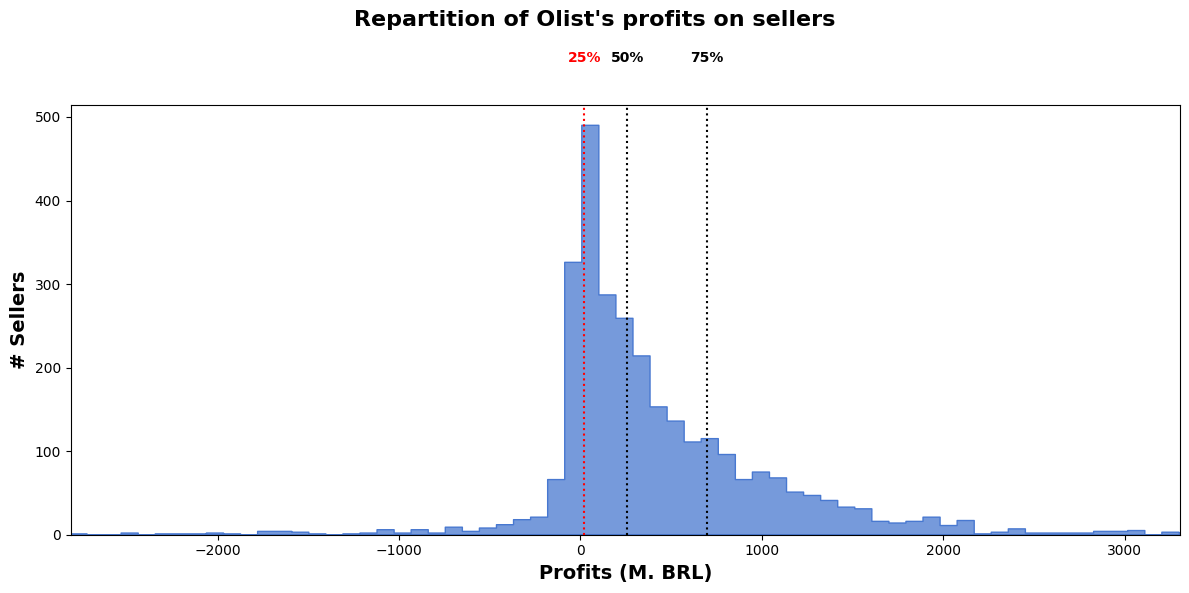

In [118]:
sns.set_palette('muted')

fig, ax = plt.subplots(figsize=(12, 6))

plt.suptitle(t="Repartition of Olist's profits on sellers",
             **STYLES['title'])

sns.histplot(sellers.profits,
             stat='count',
             element='step',
             ax=ax)

quantiles = sellers.profits.quantile(q=[.01, .25, .5, .75, .99])

ax.set_xlim(quantiles.iloc[0], quantiles.iloc[-1])
ax.set_xlabel(xlabel='Profits (M. BRL)',
              fontdict=STYLES['labels'])
ax.set_ylabel(ylabel='# Sellers',
              fontdict=STYLES['labels'])

for p, q in quantiles.iloc[1:-1].items():
    c_ = 'black'
    if p == .25:
        c_ = 'red'
    ax.axvline(x=q,
               color=c_,
               ls=':')
    ax.text(x=q,
            y=ax.get_yticks()[-1] - 30,
            s=f'{p:.0%}',
            color=c_,
            ha='center',
            va='center',
            weight='bold')

fig.tight_layout();

🎯 Referans olması açısından, **30** BRL'den daha az kâr elde eden **742** satıcıyı **düşük performans gösterenler** olarak değerlendireceğiz

### Olist kâr artırmak için ne yapabilirdi ...
### ... şu anda sahip olduğumuz bilgilerle?

### 💡 **Satıcıları kaldırmanın** mali etkisini görelim, **daha az kârlı olandan** başlayarak

### 💡 Satıcıları **artan kâr** ile **sıralıyoruz** ve son 16 ay boyunca Olist'ten kaldırıldıktan sonraki **maliyetleri** ve **gelirleri** tahmin ediyoruz

In [121]:
sorted_sellers = sellers.sort_values(by='profits') \
                    [['months_on_olist',
                      'sales',
                      'profits',
                      'revenues',
                      'quantity',
                      'cost_of_reviews']] \
                    .reset_index()

sorted_sellers.head()

,index,months_on_olist,sales,profits,revenues,quantity,cost_of_reviews
0,769,19.0,123304.83,-21439.517,13850.483,2033,35290
1,2358,20.0,200472.92,-17752.708,21647.292,1987,39400
2,1357,19.0,104288.42,-17581.158,11948.842,1775,29530
3,945,12.0,37177.52,-15542.248,4677.752,1203,20220
4,315,10.0,17535.69,-12886.431,2553.569,1018,15440


In [122]:
gross_profits_per_seller_removed = profits_gross - np.cumsum(sorted_sellers.profits[:-1])
review_costs_per_seller_removed = costs_reviews - np.cumsum(sorted_sellers.cost_of_reviews[:-1])
revenues_per_seller_removed = revenues_total - np.cumsum(sorted_sellers.revenues[:-1])

In [123]:
fees_per_seller_removed = revenues_sales - np.cumsum(sorted_sellers.sales[:-1] * .1)
suscriptions_per_seller_removed = revenues_subscription - np.cumsum(sorted_sellers.months_on_olist[:-1] * 80)

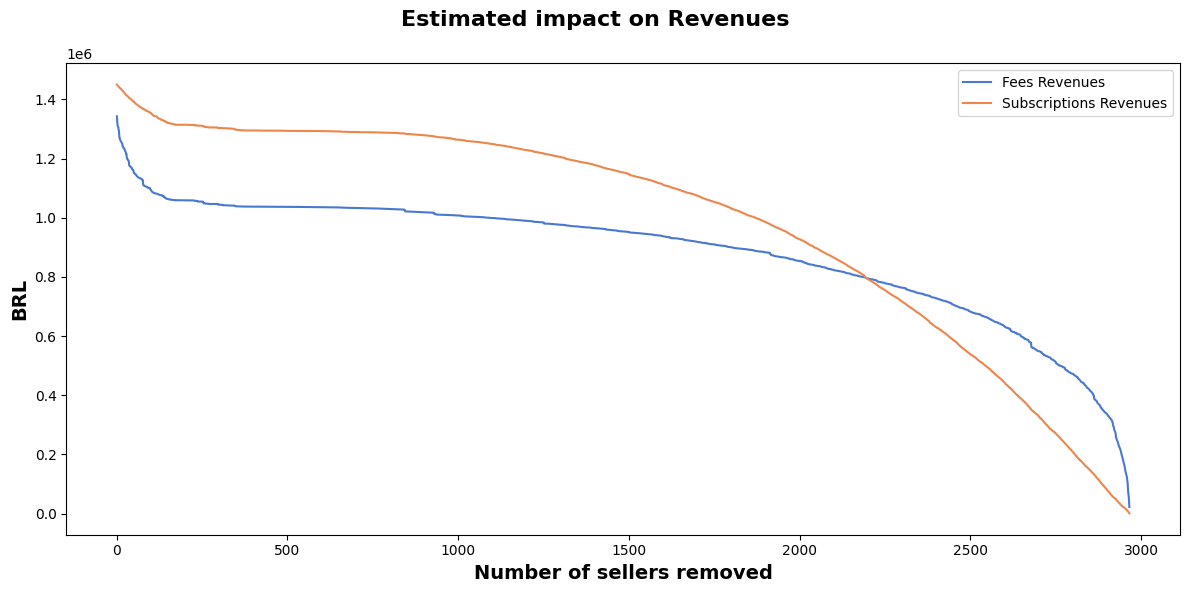

In [124]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Revenues",
             **STYLES['title'])

fees_line = sns.lineplot(x=x,
                         y=fees_per_seller_removed,
                         label='Fees Revenues',
                         ax=ax)

subscriptions_line = sns.lineplot(x=x,
                                  y=suscriptions_per_seller_removed,
                                  label='Subscriptions Revenues',
                                  ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

### BT Maliyetleri ölçekleme parametreleri $\alpha$ ve $\beta$

In [125]:
alpha, beta = 3157.27, 978.23
n_sellers = sellers.shape[0]
n_items = sellers.quantity.sum()

In [126]:
def compute_costs_of_it(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

In [127]:
new_n_sellers = n_sellers - np.arange(1, n_sellers, 1)
new_n_items = n_items - np.cumsum(sorted_sellers.quantity[:-1])

it_costs_per_seller_removed = compute_costs_of_it(new_n_sellers, new_n_items)
review_costs_per_seller_removed = sellers.cost_of_reviews.sum() - np.cumsum(sorted_sellers.cost_of_reviews[:-1])

costs_per_seller_removed = it_costs_per_seller_removed + review_costs_per_seller_removed

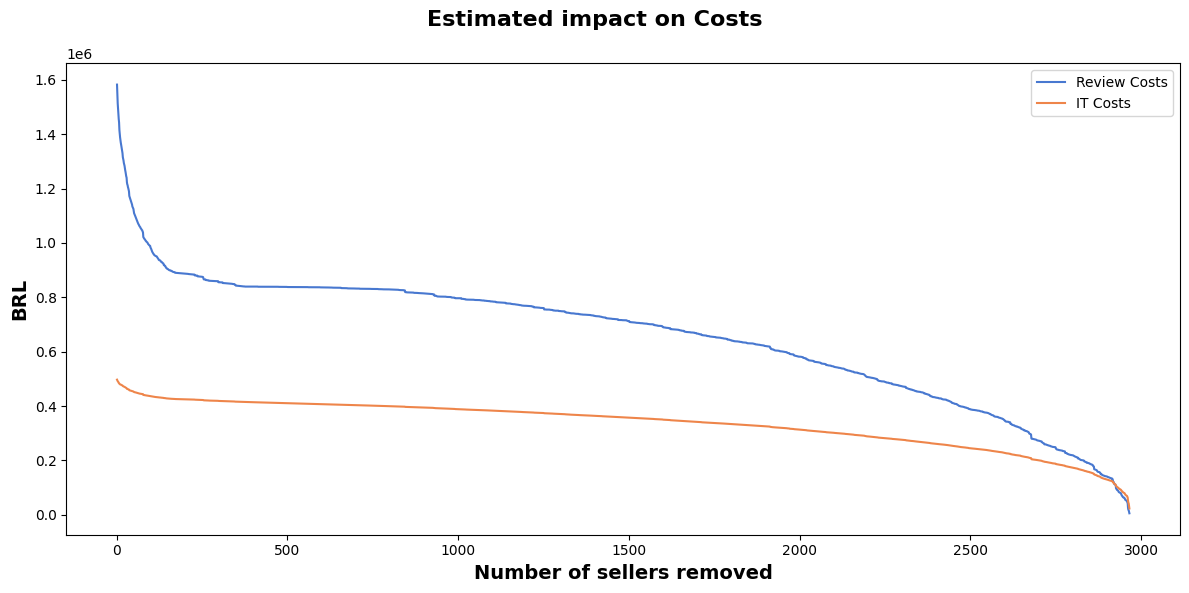

In [128]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Costs",
             **STYLES['title'])

review_costs_line = sns.lineplot(x=x,
                                 y=review_costs_per_seller_removed,
                                 label='Review Costs',
                                 ax=ax)

it_costs_line = sns.lineplot(x=x,
                             y=it_costs_per_seller_removed,
                             label='IT Costs',
                             ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

**💡 Daha az kârlı satıcıları kaldırmak, tahmini kötü yorum maliyetlerinde büyük bir azalmaya neden oluyor**  
**💡 BT Maliyetleri bu analiz için daha az önemli görünüyor**

In [129]:
# Compute final metrics (profits and margin, for each scenario!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

# Kaç tane düşük performans gösteren kaldırılmalı?

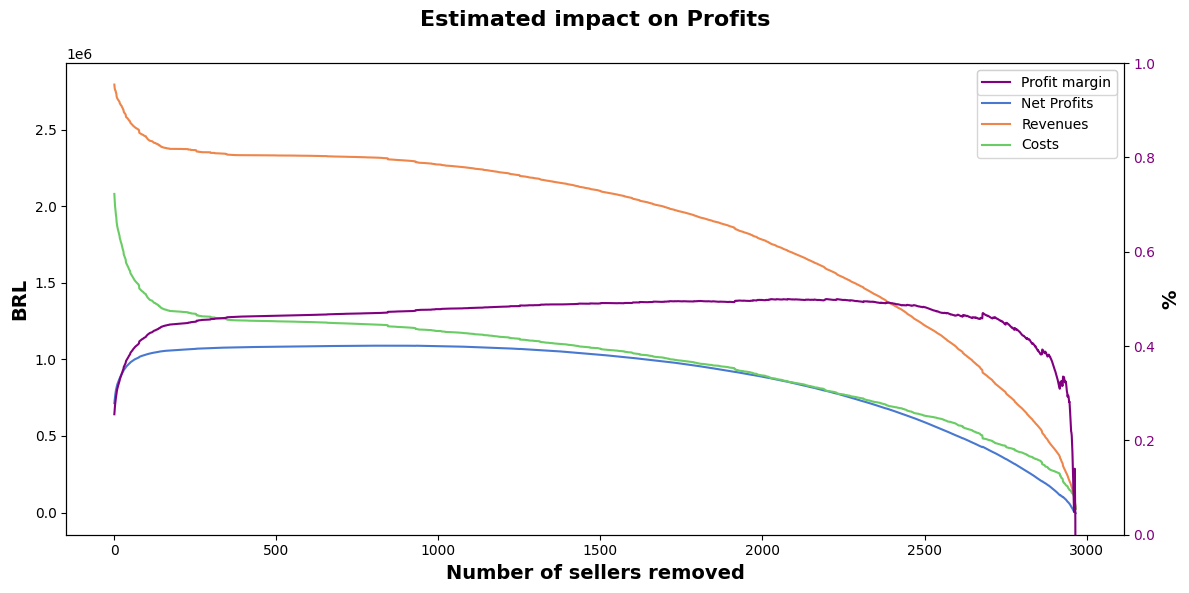

In [130]:
fig, ax = plt.subplots(figsize=(12, 6))

axs = [ax, ax.twinx()]

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Profits",
             **STYLES['title'])

net_profit_line = sns.lineplot(x=x,
                               y=profits_per_seller_removed,
                               label='Net Profits',
                               ax=axs[0])

revenue_line = sns.lineplot(x=x,
                            y=revenues_per_seller_removed,
                            label='Revenues',
                            ax=axs[0])

costs_line = sns.lineplot(x=x,
                          y=costs_per_seller_removed,
                          label='Costs',
                          ax=axs[0])

axs[0].set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
axs[0].set_ylabel('BRL',
                  fontdict=STYLES['labels'])

axs[0].tick_params(axis='y')

margin_line = sns.lineplot(x=x,
                           y=margin_per_seller_removed,
                           label='Profit margin',
                           color='purple',
                          ax=axs[1])

axs[1].set_ylabel('%',
                  fontdict=STYLES['labels'])
axs[1].tick_params(axis='y',
                   labelcolor='purple')
axs[1].set(ylim=[0, 1])

lines = [axs[1].lines[0], *axs[0].lines]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels)

fig.tight_layout()

In [131]:
# Find optimal number of sellers to remove
profits_per_seller_removed.argmax(), profits_per_seller_removed.argmax() / n_sellers, \
margin_per_seller_removed.argmax(), margin_per_seller_removed.argmax() / n_sellers

(849, 0.2861476238624874, 2196, 0.7401415571284126)

### 📊 Karar eşikleri
#### 👉 **Kâr** için optimize etmek **849 (%29)** satıcıyı kaldırmayı gerektirir
#### 👉 **Kar marjı** için optimize etmek **2196 (%76)** satıcıyı kaldırmayı gerektirir  